In [56]:
#1
import os
import cv2
import warnings
import numpy as np
import pandas as pd
import sklearn.metrics.pairwise as pairwise
!pip install insightface
!pip install onnxruntime
!pip install onnxruntime-gpu==1.15.1 # Install onnxruntime-gpu (if using GPU)
warnings.filterwarnings('ignore')  # Ignore all warnings


from insightface.app import FaceAnalysis


# configure face analysis
faceapp = FaceAnalysis(name='buffalo_l',
                       root='insightface_model',
                       providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

faceapp.prepare(ctx_id=0, det_size=(640,640), det_thresh=0.5)
# warning: don't set det_thresh < 0.3

# Load the NPZ file
file_np = np.load('dataframe_buffalo_l.npz', allow_pickle=True)
dataframe = pd.DataFrame(file_np['arr_0'], columns=file_np['arr_1'])


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [57]:

#2
def ml_search_algorithm(dataframe,feature_column,test_vector,
                        name=['Name'],thresh=0.5):
    """
    cosine similarity base search algorithm
    """
    # step-1: take the dataframe (collection of data)
    dataframe = dataframe.copy()
    # step-2: Index face embeding from the dataframe and convert into array
    X_list = dataframe[feature_column].tolist()
    x = np.asarray(X_list)

    # step-3: Cal. cosine similarity
    similar = pairwise.cosine_similarity(x,test_vector.reshape(1,-1))
    similar_arr = np.array(similar).flatten()
    dataframe['cosine'] = similar_arr

    # step-4: filter the data
    data_filter = dataframe.query(f'cosine >= {thresh}')
    if len(data_filter) > 0:
        # step-5: get the person name
        data_filter.reset_index(drop=True,inplace=True)
        argmax = data_filter['cosine'].argmax()
        person_name = data_filter.loc[argmax][name]

    else:
        person_name = 'Unknown'
        # person_role = 'Unknown'

    return person_name


In [58]:
# prompt: drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
print(dataframe)

          Name                                    Facial_Features
0   2020331001  [0.19682893, 0.64122707, 0.92124677, 0.0162257...
1   2020331001  [-0.11495488, 0.27155393, -0.40889782, -0.1075...
2   2020331001  [0.15528634, -0.64802676, -1.6971841, -0.45313...
3   2020331001  [-0.016492836, 0.45875132, -1.1043217, -0.7410...
4   2020331001  [-0.73555994, 0.48325706, -1.7735553, 0.794547...
..         ...                                                ...
79  2020331023  [0.66229016, 0.86394715, 1.5117536, -0.7504224...
80  2020331023  [-0.19615719, 0.40080374, 0.53213716, 0.073676...
81  2020331023  [1.4067243, -0.21853262, 0.5151143, -0.4643753...
82  2020331023  [0.7073579, 0.47575253, 0.8919596, -1.0168792,...
83  2020331023  [1.0251179, -0.30569282, 1.4507828, 0.01989489...

[84 rows x 2 columns]


In [60]:
from google.colab.patches import cv2_imshow


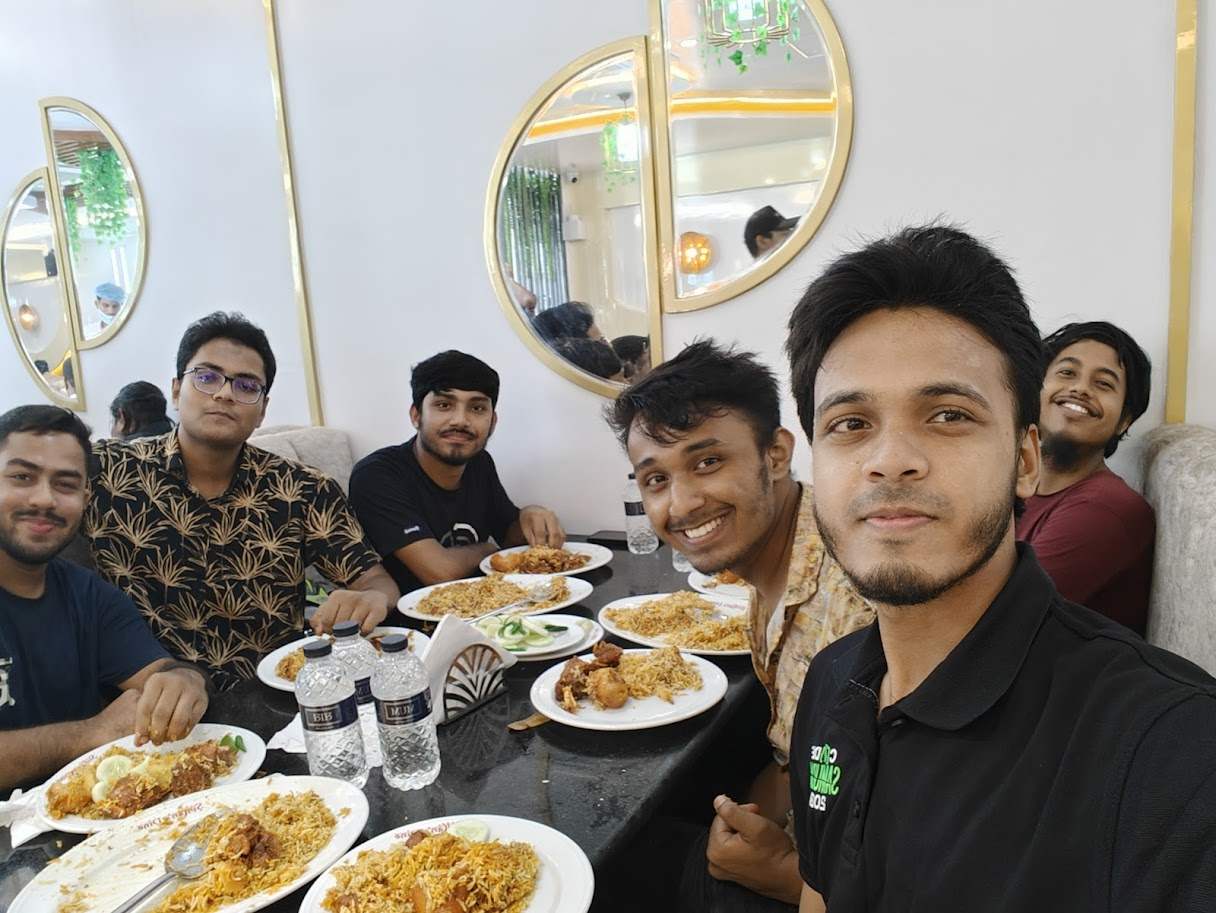

['2020331017', '2020331097', '2020331001', '2020331008']


In [61]:

#3
# step-1: take the test image and apply to insight face
# test_image =  cv2.imread('/content/drive/MyDrive/A.0/2_Fast_Face_Recognition_System/test_images/IMG-20240602-WA0018.jpg')
test_image = cv2.imread('/content/drive/MyDrive/A.0/2_Fast_Face_Recognition_System/test_images/murgi.jpg')
# test_image = cv2.imread('/content/drive/MyDrive/A.0/2_Fast_Face_Recognition_System/test_image_1.jpg')
cv2_imshow(test_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
results = faceapp.get(test_image)

# step-2: use for loop and extract each embedding and pass to ml_search_algorithm
identified_names = []
for res in results:
    embeddings = res['embedding']
    person_name = ml_search_algorithm(dataframe,  # No need for person_role
                                       'Facial_Features',
                                       test_vector=embeddings,
                                       name=['Name'],
                                       thresh=0.5)
    # print(str(person_name))
    if isinstance(person_name, pd.Series):
        # Extract the name as a string from the Series
        name_str = person_name.values[0]  # or person_name.iloc[0]
    else:
        # If it's already a string, use it directly
        name_str = person_name

    # Append to the list
    if name_str!= "Unknown":
        identified_names.append(name_str)



print(identified_names)
# print("       ")
    # print(person_name) # Just print the name